# Preprocessing with PCA

In [ ]:
from tensorflow import  keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import utils #np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

import tensorflow as tf
init_notebook_mode(connected=True)
%matplotlib inline

def loadData(name):
    #data_path = os.path.join(os.getcwd(),'data')
    #data_path='/content/drive/MyDrive/data_indian'
    if name == 'IP':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.2 # VALIDATION SPLIT

X, y = loadData(dataset)

X.shape, y.shape

K = 30 if dataset == 'IP' else 15
#K=120
X,pca = applyPCA(X,numComponents=K)

X.shape

zeros=np.zeros((y.shape[0],y.shape[1]+2,K)) # zeros from left and right
zeros[0:y.shape[0],1:y.shape[1]+1,:]=X # [1,y.shape[1]+1)
X_padded=zeros
print(X_padded)
input_flatten=X_padded.reshape(-1,K) #check how it is reshaped
label=y.reshape(y.shape[0]*y.shape[1])
#print(input_flatten)
print(input_flatten.shape)
print(label.shape)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-9.20134055e-01  1.54299476e+00  9.92465949e-01 ...  1.04262548e+00
   -1.16618377e-01 -8.14811298e-01]
  [-1.08665533e+00  7.17241111e-01  9.47674862e-01 ...  8.52689363e-01
   -2.36686568e-01  2.01748830e-02]
  ...
  [-3.53772246e-01  7.95436161e-01 -1.61740288e-01 ...  9.24008551e-02
    1.21146544e+00  4.63188316e-01]
  [-4.69610410e-01  4.54619336e-01 -6.29329877e-03 ...  9.69387890e-03
    1.09755247e+00  4.43589090e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.04797403e+00  8.84788664e-01  1.01703462e+00 ...  3.77104807e-01
   -7.01367197e-01 -2.98649864e+00]
  [-1.39119007e+00 -3.08386795e-01  8.11145100e-01 ... -3.76835027e-01
   -3.51969563e-01  5.25179263e-01]
  ...
  [-3.43257059e-01  8.3

In [ ]:
print(label)

[0 0 0 ... 0 0 0]


In [ ]:
import time 
start=time.time()
input_big=np.zeros([y.shape[0]*y.shape[1],K*3])
list1=[]
count=0
ind1=0
ind2=1

for i in range(0,input_flatten.shape[0]) :
  if input_flatten[i,:].all() != np.zeros([1,K]).all(): ##
    list1.append(i)
    l=input_flatten[i-1,:]
    m=input_flatten[i,:]
    r=input_flatten[i+1,:]
    row=np.concatenate((l, m,r), axis=0)
    row.reshape([1,row.shape[0]])
    input_big[count,:]=row
    count=count+1

end=time.time()
print(f"elapsed time : {end - start}")



elapsed time : 3.076359987258911


In [ ]:
#try dot product method to reduce the input to 32
start=time.time()
import numpy as np

input_big=np.zeros([y.shape[0]*y.shape[1],K + 2])
list1=[]
count=0
ind1=0
ind2=1

for i in range(0,input_flatten.shape[0]) :
  if input_flatten[i,:].all() != np.zeros([1,K]).all(): ##
    list1.append(i)
    l=input_flatten[i-1,:]
    m=input_flatten[i,:]
    r=input_flatten[i+1,:]
    row=np.concatenate(  (   [abs( np.dot(m, l) )] , m , [abs( np.dot(m, r) )]    ), axis=0 )
    row.reshape([1,row.shape[0]])
    input_big[count,:]=row
    count=count+1
end=time.time()
print(f" elapsed time : {end - start} ")

 elapsed time : 4.4021241664886475 


In [ ]:
print(len(list1))
#print(list1)
print(input_big.shape)
#print(input_big)
print(label.shape)
#normalize 
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) #make sure you did normalization in a correct way
scaled_samples = scaler.fit_transform(input_big.reshape(-1,3*K)) ##### old .reshape(-1,3*K) not needed
#scaled_samples = scaler.fit_transform(input_big.reshape(-1,K+2))
print(scaled_samples.shape)
# get the indices of blank pixels 
# they are found in the label 
result = np. where(label == 0)
print(result)
print(result[0].shape)
#for index in result[0]:
  #print(index)
scaled_samples_withoutzero=np.delete(scaled_samples, result[0], axis=0)
print(scaled_samples_withoutzero.shape)

# add more data
#old
a=scaled_samples_withoutzero[:,0:K]
m=scaled_samples_withoutzero[:,K:2*K] #should we add 1?
b=scaled_samples_withoutzero[:,2*K:3*K] #should we add 1?
#a=scaled_samples_withoutzero[:,0:1]
#m=scaled_samples_withoutzero[:,1:K+1]
#b=scaled_samples_withoutzero[:,K+1:K+2]

scaled_samples2=np.concatenate((b, m,a), axis=1)

print(scaled_samples2.shape)
#duplicate
scaled_samples_duplicate=np.concatenate((scaled_samples_withoutzero,scaled_samples2), axis=0)
print(scaled_samples_duplicate.shape)
print(label.shape)
label_withoutzero=np.delete(label, result[0], axis=0)
print(label_withoutzero.shape)
label_duplicate=np.concatenate( ( label_withoutzero , label_withoutzero ) , axis=0 )
print(label_duplicate.shape)

#subtract one
label_duplicate=label_duplicate - 1

207400
(207400, 45)
(207400,)
(207400, 45)
(array([     0,      1,      2, ..., 207397, 207398, 207399]),)
(164624,)
(42776, 45)
(42776, 45)
(85552, 45)
(207400,)
(42776,)
(85552,)


I need to remove rows that correspond to blank pixel from scaled samples

In [ ]:
from sklearn.utils import shuffle
X_shuff=scaled_samples_duplicate
y_shuff = label_duplicate
X_shuff, y_shuff = shuffle(X_shuff, y_shuff, random_state=0)
print(X_shuff)
print(y_shuff)

[[0.14981061 0.26210349 0.42856506 ... 0.27877577 0.48531029 0.35759125]
 [0.14536897 0.41136936 0.43371367 ... 0.27385269 0.48933966 0.35313988]
 [0.14421738 0.41094607 0.4374574  ... 0.27637756 0.48613922 0.36339411]
 ...
 [0.13064548 0.40007608 0.44973635 ... 0.27304639 0.49273097 0.35641058]
 [0.11303287 0.21711226 0.45518463 ... 0.27387358 0.48234331 0.35866548]
 [0.18446771 0.26261939 0.4369453  ... 0.2829602  0.4916563  0.35952726]]
[6 1 1 ... 1 0 2]


In [ ]:
print(y_shuff.shape)

(85552,)


In [ ]:
print(y.shape)
print(X.shape)

(610, 340)
(610, 340, 15)


In [ ]:
#split into test and training set 
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test=splitTrainTestSet(X_shuff,y_shuff, testRatio=0.1, randomState=345)

# Preprocess without PCA 

In [ ]:
from tensorflow import  keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import utils #np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

import tensorflow as tf
init_notebook_mode(connected=True)
%matplotlib inline

def loadData(name):
    #data_path = os.path.join(os.getcwd(),'data')
    #data_path='/content/drive/MyDrive/data_indian'
    if name == 'IP':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test



In [ ]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.2 # VALIDATION SPLIT
#load data
X, y = loadData(dataset)
X.shape, y.shape


((610, 340, 103), (610, 340))

In [ ]:

#preprocessing
K=X.shape[2]
zeros=np.zeros((y.shape[0],y.shape[1]+2,K)) # zeros from left and right
zeros[0:y.shape[0],1:y.shape[1]+1,:]=X # [1,y.shape[1]+1)
X_padded=zeros
input_flatten=X_padded.reshape(-1,K) #check how it is reshaped
label=y.reshape(y.shape[0]*y.shape[1])
input_big=np.zeros([y.shape[0]*y.shape[1],K*3])
list1=[]
count=0
ind1=0
ind2=1

for i in range(0,input_flatten.shape[0]) :
  if input_flatten[i,:].all() != np.zeros([1,K]).all(): ##
    list1.append(i)
    l=input_flatten[i-1,:]
    m=input_flatten[i,:]
    r=input_flatten[i+1,:]
    row=np.concatenate((l, m,r), axis=0)
    row.reshape([1,row.shape[0]])
    input_big[count,:]=row
    count=count+1


from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))  # make sure you did normalization in a correct way
scaled_samples = scaler.fit_transform(input_big.reshape(-1,3*K)) ##### was 30

# get the indices of blank pixels 
# they are found in the label 
result = np. where(label == 0) # in real scenerio this is not found 
scaled_samples_withoutzero=np.delete(scaled_samples, result[0], axis=0)

In [ ]:
# add more data
#old
a=scaled_samples_withoutzero[:,0:K]
m=scaled_samples_withoutzero[:,K:2*K] #should we add 1?
b=scaled_samples_withoutzero[:,2*K:3*K] #should we add 1?
#a=scaled_samples_withoutzero[:,0:1]
#m=scaled_samples_withoutzero[:,1:K+1]
#b=scaled_samples_withoutzero[:,K+1:K+2]

scaled_samples2=np.concatenate((b, m,a), axis=1)

#duplicate
scaled_samples_duplicate=np.concatenate((scaled_samples_withoutzero,scaled_samples2), axis=0)
print(scaled_samples_duplicate.shape)

print(label.shape)
label_withoutzero=np.delete(label, result[0], axis=0)
print(label_withoutzero.shape)
label_duplicate=np.concatenate( ( label_withoutzero , label_withoutzero ) , axis=0 )
print(label_duplicate.shape)


(85552, 309)
(207400,)
(42776,)
(85552,)


In [ ]:
#subtract one
label_duplicate=label_duplicate - 1


# Preprocess with modified PCA

In [ ]:
from tensorflow import  keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import utils #np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import time
import tensorflow as tf
init_notebook_mode(connected=True)
%matplotlib inline

def loadData(name):
    #data_path = os.path.join(os.getcwd(),'data')
    #data_path='/content/drive/MyDrive/data_indian'
    if name == 'IP':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def my_applyPCA(X, numComponents=75):
    start_learn=time.time()
    newX_reshaped = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    pca.fit_transform(newX_reshaped)
    end_learn=time.time()
    components=pca.components_
    #print(f' components shape {components.shape}')
    #print(f' components  {components[:,0]}')
    start_project=time.time()
    newX=np.dot(components,newX_reshaped.T - pca.mean_.reshape(-1,1))
    #print(newX.shape)
    #print(newX[:,0])
    newX=newX.T
    #print(newX.shape)
    newX=np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    end_project=time.time()
    print(f"time taken to learn {end_learn-start_learn}")
    print(f"time taken to project {end_project-start_project}")
    print(f"total time taken  {end_project-start_learn}")
    return newX, pca

In [ ]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.2 # VALIDATION SPLIT
X, y = loadData(dataset)

X.shape, y.shape

K = 30 if dataset == 'IP' else 15
#K=120
X,pca = my_applyPCA(X,numComponents=K)

X.shape

time taken to learn 2.81906795501709
time taken to project 0.1065683364868164
total time taken  2.9256420135498047


(610, 340, 15)

In [ ]:
print(X[0,0,:])

[-5150.19004357  6795.05276995  1532.35146075   410.03013362
  -259.85615715  -832.89897019   293.23977612   278.3852123
  -285.60996876   251.20856963  -283.85345611    11.78175473
    92.30653989    -9.5491515    -59.46923742]


In [ ]:
zeros=np.zeros((y.shape[0],y.shape[1]+2,K)) # zeros from left and right
zeros[0:y.shape[0],1:y.shape[1]+1,:]=X # [1,y.shape[1]+1)
X_padded=zeros
print(X_padded)
input_flatten=X_padded.reshape(-1,K) #check how it is reshaped
label=y.reshape(y.shape[0]*y.shape[1])
#print(input_flatten)
print(input_flatten.shape)
print(label.shape)

In [ ]:
import time 
start=time.time()
input_big=np.zeros([y.shape[0]*y.shape[1],K*3])
list1=[]
count=0
ind1=0
ind2=1

for i in range(0,input_flatten.shape[0]) :
  if input_flatten[i,:].all() != np.zeros([1,K]).all(): ##
    #list1.append(i)
    l,m,r=input_flatten[i-1,:],input_flatten[i,:],input_flatten[i+1,:]
    #m=input_flatten[i,:]
    #r=input_flatten[i+1,:]
    row=np.concatenate((l, m,r), axis=0)
    #row.reshape([1,row.shape[0]])
  
    input_big[count,:]=row
    count=count+1

end=time.time()
print(f"elapsed time : {end - start}")




elapsed time : 2.4401004314422607


In [ ]:
import time 
start=time.time()
input_big=np.zeros([y.shape[0]*y.shape[1],K*3])
list1=[]
count=0
ind1=0
ind2=1

for i in range(0,input_flatten.shape[0]) :
  if input_flatten[i,:].all() != np.zeros([1,K]).all(): ##

    input_big[count,:]=np.concatenate((input_flatten[i-1,:], input_flatten[i,:],input_flatten[i+1,:]), axis=0)
    count=count+1

end=time.time()
print(f"elapsed time : {end - start}")




elapsed time : 2.472507953643799


In [ ]:
print(len(list1))
#print(list1)
print(input_big.shape)
#print(input_big)
print(label.shape)
#normalize 
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) #make sure you did normalization in a correct way
scaled_samples = scaler.fit_transform(input_big.reshape(-1,3*K)) ##### old .reshape(-1,3*K) not needed
#scaled_samples = scaler.fit_transform(input_big.reshape(-1,K+2))
print(scaled_samples.shape)
# get the indices of blank pixels 
# they are found in the label 
result = np. where(label == 0)
print(result)
print(result[0].shape)
#for index in result[0]:
  #print(index)
scaled_samples_withoutzero=np.delete(scaled_samples, result[0], axis=0)
print(scaled_samples_withoutzero.shape)

207400
(207400, 45)
(207400,)
(207400, 45)
(array([     0,      1,      2, ..., 207397, 207398, 207399]),)
(164624,)
(42776, 45)


In [ ]:
# add more data
#old
a=scaled_samples_withoutzero[:,0:K]
m=scaled_samples_withoutzero[:,K:2*K] #should we add 1?
b=scaled_samples_withoutzero[:,2*K:3*K] #should we add 1?
#a=scaled_samples_withoutzero[:,0:1]
#m=scaled_samples_withoutzero[:,1:K+1]
#b=scaled_samples_withoutzero[:,K+1:K+2]

scaled_samples2=np.concatenate((b, m,a), axis=1)

print(scaled_samples2.shape)
#duplicate
scaled_samples_duplicate=np.concatenate((scaled_samples_withoutzero,scaled_samples2), axis=0)
print(scaled_samples_duplicate.shape)
print(label.shape)
label_withoutzero=np.delete(label, result[0], axis=0)
print(label_withoutzero.shape)
label_duplicate=np.concatenate( ( label_withoutzero , label_withoutzero ) , axis=0 )
print(label_duplicate.shape)

(42776, 45)
(85552, 45)
(207400,)
(42776,)
(85552,)


In [ ]:
#subtract one
label_duplicate=label_duplicate - 1


# Preprocess spectral only

In [ ]:
from tensorflow import  keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import utils #np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

import tensorflow as tf
init_notebook_mode(connected=True)
%matplotlib inline

def loadData(name):
    #data_path = os.path.join(os.getcwd(),'data')
    #data_path='/content/drive/MyDrive/data_indian'
    if name == 'IP':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data_path='/content/drive/MyDrive/data_hyper'
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.2

X, y = loadData(dataset)

X.shape, y.shape

K = 30 if dataset == 'IP' else 15
#K=120
X,pca = applyPCA(X,numComponents=K)

X.shape

label=y.reshape(-1)

#normalize 
input=X.reshape(-1,K)
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_samples = scaler.fit_transform(input) ##### was 30

print(scaled_samples.shape)

# get the indices of blank pixels 
# they are found in the label 
result = np. where(label == 0)
print(result)
print(result[0].shape)
#for index in result[0]:
  #print(index)
scaled_samples_withoutzero=np.delete(scaled_samples, result[0], axis=0)
print(scaled_samples_withoutzero.shape)

label_withoutzero=np.delete(label, result[0], axis=0)
label_withoutzero=label_withoutzero-1
print(label_withoutzero.shape)



(207400, 15)
(array([     0,      1,      2, ..., 207397, 207398, 207399]),)
(164624,)
(42776, 15)
(42776,)


# Train


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.regularizers import l2

In [ ]:
model = Sequential([
    Dense(units=512, input_shape=(3*K,), activation='relu'), #was 30
    Dense(units=256, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=128, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=32, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=256, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=128, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=32, activation='relu',bias_regularizer=l2(0.01)),
    Dropout(0.5),    
    Dense(units=9, activation='softmax') # [0,16) ## this is specific to each dataset
])

In [ ]:
#train a smaller model test 
model = Sequential([
    Dense(units=256, input_shape=(3*K,), activation='relu'), #was 30
    Dense(units=128, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)),
    Dropout(0.5),    
    Dense(units=9, activation='softmax') # [0,16) ## this is specific to each dataset
])



In [ ]:
#train a smaller model test 
model = Sequential([
    Dense(units=128, input_shape=(3*K,), activation='relu'), #was 30
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)),
    Dropout(0.5),    
    Dense(units=9, activation='softmax') # [0,16) ## this is specific to each dataset
])



In [ ]:
#train a smaller model test  - two dot plus middle 
model = Sequential([
    Dense(units=128, input_shape=(K+2,), activation='relu'), #was 30
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)),
    Dropout(0.5),    
    Dense(units=9, activation='softmax') # [0,16) ## this is specific to each dataset
])



In [ ]:
#train a smaller model test spectral-spatial
model = Sequential([
    Dense(units=64, input_shape=(3*K,), activation='relu'), #was 30
    Dense(units=32, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=16, activation='relu',bias_regularizer=l2(0.01)),
    #Dropout(0.2),    
    Dense(units=9, activation='softmax') # [0,16) ## this is specific to each dataset
])


In [ ]:
#train a smaller model for spectral only 
model = Sequential([
    Dense(units=64, input_shape=(K,), activation='relu'), #was 30
    Dense(units=32, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=16, activation='relu',bias_regularizer=l2(0.01)),
    #Dropout(0.2),    
    Dense(units=9, activation='softmax') # [0,16) ## this is specific to each dataset
])


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #reviw  0.0001

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2944      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 9)                 153       
                                                                 
Total params: 5,705
Trainable params: 5,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# for spatial duplicate 
model.fit(
      x=X
    , y=y
    , validation_split=0.1
    , batch_size=10
    , epochs=800
    , verbose=2
)

Epoch 1/200
7700/7700 - 33s - loss: 1.0316 - accuracy: 0.6028 - val_loss: 0.6330 - val_accuracy: 0.7196 - 33s/epoch - 4ms/step
Epoch 2/200
7700/7700 - 33s - loss: 0.7537 - accuracy: 0.6808 - val_loss: 0.5953 - val_accuracy: 0.7262 - 33s/epoch - 4ms/step
Epoch 3/200
7700/7700 - 35s - loss: 0.6694 - accuracy: 0.7184 - val_loss: 0.5610 - val_accuracy: 0.7592 - 35s/epoch - 5ms/step
Epoch 4/200
7700/7700 - 31s - loss: 0.6101 - accuracy: 0.7488 - val_loss: 0.4776 - val_accuracy: 0.7830 - 31s/epoch - 4ms/step
Epoch 5/200
7700/7700 - 31s - loss: 0.5767 - accuracy: 0.7606 - val_loss: 0.4831 - val_accuracy: 0.7911 - 31s/epoch - 4ms/step
Epoch 6/200
7700/7700 - 31s - loss: 0.5535 - accuracy: 0.7703 - val_loss: 0.4671 - val_accuracy: 0.7931 - 31s/epoch - 4ms/step
Epoch 7/200
7700/7700 - 31s - loss: 0.5292 - accuracy: 0.7786 - val_loss: 0.4102 - val_accuracy: 0.8049 - 31s/epoch - 4ms/step
Epoch 8/200
7700/7700 - 31s - loss: 0.4941 - accuracy: 0.7929 - val_loss: 0.3692 - val_accuracy: 0.8467 - 31s/e

summary of the previous results 
max ac 96 at 200
after 200 barely there is an improvement 

In [ ]:
#train a smaller model test spectral-spatial winth independent test split  

model.fit(
    
      x=X_train
    , y=y_train
    , validation_split=0.1
    , batch_size=10
    , epochs=800
    , verbose=2

)

Epoch 1/800
6930/6930 - 13s - loss: 1.3244 - accuracy: 0.5400 - val_loss: 0.9531 - val_accuracy: 0.6196 - 13s/epoch - 2ms/step
Epoch 2/800
6930/6930 - 12s - loss: 0.8478 - accuracy: 0.6414 - val_loss: 0.7714 - val_accuracy: 0.6736 - 12s/epoch - 2ms/step
Epoch 3/800
6930/6930 - 12s - loss: 0.7167 - accuracy: 0.7011 - val_loss: 0.6706 - val_accuracy: 0.7009 - 12s/epoch - 2ms/step
Epoch 4/800
6930/6930 - 12s - loss: 0.6360 - accuracy: 0.7331 - val_loss: 0.6066 - val_accuracy: 0.7342 - 12s/epoch - 2ms/step
Epoch 5/800
6930/6930 - 12s - loss: 0.5986 - accuracy: 0.7434 - val_loss: 0.5850 - val_accuracy: 0.7400 - 12s/epoch - 2ms/step
Epoch 6/800
6930/6930 - 12s - loss: 0.5800 - accuracy: 0.7480 - val_loss: 0.5697 - val_accuracy: 0.7448 - 12s/epoch - 2ms/step
Epoch 7/800
6930/6930 - 12s - loss: 0.5666 - accuracy: 0.7532 - val_loss: 0.5644 - val_accuracy: 0.7445 - 12s/epoch - 2ms/step
Epoch 8/800
6930/6930 - 12s - loss: 0.5555 - accuracy: 0.7562 - val_loss: 0.5476 - val_accuracy: 0.7590 - 12s/e

In [ ]:
# for spatial not duplicate 
model.fit(
      x=scaled_samples_withoutzero
    , y=label_withoutzero - 1
    , validation_split=0.1
    , batch_size=10
    , epochs=500
    , verbose=2
)

Epoch 1/500
3850/3850 - 7s - loss: 1.6391 - accuracy: 0.4344 - val_loss: 0.4234 - val_accuracy: 1.0000 - 7s/epoch - 2ms/step
Epoch 2/500
3850/3850 - 6s - loss: 1.1015 - accuracy: 0.5578 - val_loss: 0.3966 - val_accuracy: 0.8261 - 6s/epoch - 1ms/step
Epoch 3/500
3850/3850 - 6s - loss: 0.8820 - accuracy: 0.6299 - val_loss: 0.4518 - val_accuracy: 0.8090 - 6s/epoch - 2ms/step
Epoch 4/500
3850/3850 - 6s - loss: 0.7355 - accuracy: 0.7040 - val_loss: 0.4633 - val_accuracy: 0.7899 - 6s/epoch - 1ms/step
Epoch 5/500
3850/3850 - 6s - loss: 0.6641 - accuracy: 0.7154 - val_loss: 0.3842 - val_accuracy: 0.8186 - 6s/epoch - 1ms/step
Epoch 6/500
3850/3850 - 6s - loss: 0.6274 - accuracy: 0.7229 - val_loss: 0.4612 - val_accuracy: 0.7433 - 6s/epoch - 2ms/step
Epoch 7/500
3850/3850 - 6s - loss: 0.6049 - accuracy: 0.7272 - val_loss: 0.4709 - val_accuracy: 0.7506 - 6s/epoch - 1ms/step
Epoch 8/500
3850/3850 - 6s - loss: 0.5899 - accuracy: 0.7311 - val_loss: 0.4037 - val_accuracy: 0.7571 - 6s/epoch - 1ms/step


summary 
acc 94.5 at epoch 200
acc 96.5 at 500

In [ ]:
#for single 

model.fit(
   
      x= scaled_samples_withoutzero
    , y=label_withoutzero 
    , validation_split=0.1
    , batch_size=10
    , epochs=500
    , verbose=2
)

Epoch 1/500
3850/3850 - 6s - loss: 1.7473 - accuracy: 0.3825 - val_loss: 0.5638 - val_accuracy: 1.0000 - 6s/epoch - 2ms/step
Epoch 2/500
3850/3850 - 6s - loss: 1.1915 - accuracy: 0.5677 - val_loss: 0.4913 - val_accuracy: 0.8340 - 6s/epoch - 1ms/step
Epoch 3/500
3850/3850 - 6s - loss: 0.9978 - accuracy: 0.6053 - val_loss: 0.4329 - val_accuracy: 0.7833 - 6s/epoch - 1ms/step
Epoch 4/500
3850/3850 - 6s - loss: 0.9405 - accuracy: 0.6068 - val_loss: 0.4661 - val_accuracy: 0.7793 - 6s/epoch - 1ms/step
Epoch 5/500
3850/3850 - 6s - loss: 0.9036 - accuracy: 0.6227 - val_loss: 0.4393 - val_accuracy: 0.7679 - 6s/epoch - 1ms/step
Epoch 6/500
3850/3850 - 6s - loss: 0.8643 - accuracy: 0.6515 - val_loss: 0.4212 - val_accuracy: 0.7803 - 6s/epoch - 2ms/step
Epoch 7/500
3850/3850 - 6s - loss: 0.8178 - accuracy: 0.6782 - val_loss: 0.4287 - val_accuracy: 0.7849 - 6s/epoch - 1ms/step
Epoch 8/500
3850/3850 - 6s - loss: 0.7672 - accuracy: 0.6898 - val_loss: 0.3847 - val_accuracy: 0.7943 - 6s/epoch - 2ms/step


summary 
at 500 acc 92
at 200 acc







# saving model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('ANN_MY_spsp_withoutblank_PU_reduced7_splited')

INFO:tensorflow:Assets written to: ANN_MY_spsp_withoutblank_PU_reduced7_splited/assets


# Testing

In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/ANN_MY_spsp_withoutblank_PU')

In [ ]:
#reduced
model=keras.models.load_model('/content/drive/MyDrive/ANN_MY_spsp_withoutblank_PU_reduced7_splited')

In [ ]:
!pip install spectral 

In [ ]:
import spectral

In [ ]:
print(y.shape)

(610, 340)


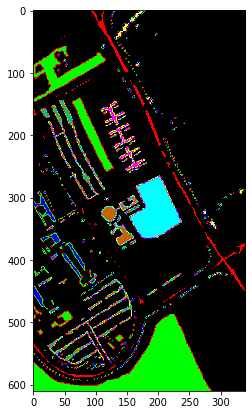

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predictions = model.predict(
      #x=scaled_samples_withoutzero
      x=X_test      
    , batch_size=10 # what is the defualt
    , verbose=0
)  

In [ ]:
rounded_predictions = np.argmax(predictions, axis=-1) #review the axis

In [ ]:
target_names = ['Asphalt', 'Meadows', 'Gravel', 'Trees'  ## you should change this ####
                        ,'Painted metal sheets', 'Bare Soil', 'Bitumen', 
                        'Self-Blocking Bricks', 'Shadows']
#print( classification_report( label_withoutzero-1, rounded_predictions,target_names=target_names ) ) ## this should be made on testing data not training
print( classification_report( y_test, rounded_predictions,target_names=target_names ) )

                      precision    recall  f1-score   support

             Asphalt       0.97      0.97      0.97      1326
             Meadows       0.98      0.99      0.98      3730
              Gravel       0.90      0.85      0.87       420
               Trees       0.98      0.97      0.97       613
Painted metal sheets       1.00      1.00      1.00       269
           Bare Soil       0.97      0.94      0.95      1006
             Bitumen       0.97      0.94      0.96       266
Self-Blocking Bricks       0.89      0.94      0.91       737
             Shadows       1.00      1.00      1.00       189

            accuracy                           0.97      8556
           macro avg       0.96      0.95      0.96      8556
        weighted avg       0.97      0.97      0.97      8556



In [ ]:
#test for all pixels
predictions = model.predict(
      x=scaled_samples_withoutzero
      #x=X_test      
    , batch_size=10 # what is the defualt
    , verbose=0
)  
rounded_predictions = np.argmax(predictions, axis=-1) #review the axis

In [ ]:
zeros_arr=np.zeros(y.shape[0]*y.shape[1])
print(zeros_arr.shape)

(207400,)


In [ ]:
result2 = np. where(label != 0)
print(result2[0].shape)

(42776,)


In [ ]:
zeros_arr[result2[0]]=rounded_predictions + 1
print(zeros_arr.shape)
print(zeros_arr)

(207400,)
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
outputs=zeros_arr.reshape(y.shape[0],y.shape[1])

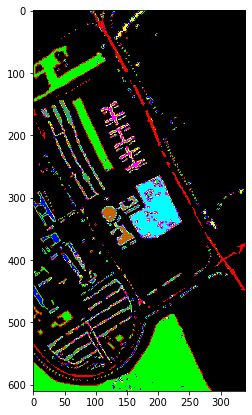

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

# throughput

In [ ]:
N_batch=1000
batched_input=scaled_samples_duplicate[0:N_batch]
print(batched_input.shape)

(1000, 45)


In [ ]:
#load optimized model with FP32 precision 
#import tensorflow.contrib.tensorrt 
loaded_spsp = tf.saved_model.load('/content/drive/MyDrive/ANN_MY_spsp_withoutblank_PU_reduced6')

#they return dictionary as signiture (what are signatures) 
infer_spsp=loaded_spsp.signatures['serving_default']
print(infer_spsp.structured_outputs) #structure output 

{'dense_7': TensorSpec(shape=(None, 9), dtype=tf.float32, name='dense_7')}


In [ ]:
import time
def predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=10, N_run=100):

  elapsed_time = []
  all_preds = []
  batch_size = batched_input.shape[0] 

  tensor_list = tf.convert_to_tensor(batched_input) # change to tensor
  tensor_list = tf.cast(tensor_list, tf.float32)  # change to float32

  for i in range(N_warmup_run):
    labeling = infer(tensor_list)
    preds = labeling['dense_7'].numpy()

  for i in range(N_run):
    start_time = time.time()

    labeling = infer(tensor_list)

    preds = labeling['dense_7'].numpy()

    end_time = time.time()

    elapsed_time = np.append(elapsed_time, end_time - start_time)
    
    all_preds.append(preds)

    if i % 50 == 0:
      print('Steps {}-{} average: {:4.1f}ms'.format(i, i+50, (elapsed_time[-50:].mean()) * 1000))

  print('Throughput: {:.0f} pixels/s'.format(N_run * batch_size / elapsed_time.sum()))
  return all_preds

In [ ]:
pred=predict_and_benchmark_throughput(batched_input, infer_spsp, N_warmup_run=10, N_run=500)

Steps 0-50 average:  1.0ms
Steps 50-100 average:  0.8ms
Steps 100-150 average:  0.9ms
Steps 150-200 average:  0.8ms
Steps 200-250 average:  0.8ms
Steps 250-300 average:  0.9ms
Steps 300-350 average:  0.9ms
Steps 350-400 average:  0.8ms
Steps 400-450 average:  0.8ms
Steps 450-500 average:  0.8ms
Throughput: 1187057 pixels/s
